[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HSinger04/VOGUE-Reimplementation/blob/main/cryu854/TryOn.ipynb)

# Prerequisites

A Google Drive account is needed for this notebook to be run. In the cell under "Mount drive for dataset and weights", please state under ```PRT_DIRS``` as key your identifier (e.g. "hermann") and as value a directory dedicated to this notebook (e.g. "Latent2Images"). Then, set ```PRT_DIR = PRT_DIRS[<your_identifier>]```  Then, go to 
https://drive.google.com/drive/folders/1u2xu7bSrWxrbUxk-dT-UvEJq8IjdmNTP, right-click on "ffhq-dataset" at "Shared with me > ffhq-dataset" and click on "Add a shortcut to Drive". Create the shortcut the directory dedicated to this notebook. Please go to https://drive.google.com/drive/folders/1BO98vdtQSUjRKqlIIoiRVtBM_mCEcoFc and do the same as you did with "ffhq-dataset" with "official_1024x1024" at "Shared with me > StyleGAN2models > weights-ffhq > official_1024x1024". Do the same with https://drive.google.com/drive/folders/1-0uzbtuEQkKNbuO-o4-Ly2DJZtsL7Cyy?usp=sharing and https://drive.google.com/drive/folders/1w158HtXV6Z1TH0PRdByiz6P1K8FhyQyq?usp=sharing.

This is needed, as "ffhq-dataset" points to the training dataset which is too large to download / upload oneself, "official_1024x1024" contains weights for the StyleGAN2 generator used in this notebook and also, tensorboard logs and training variables (e.g. encoder weights) get saved in the folder dedicated to this notebook.

When you run the cell under "Mount drive for dataset and weights", you will need to MANUALLY authenticate access to Google Drive.


## Mount drive for dataset and weights

In [ ]:
from google.colab import drive

PRT_DIRS = {"hermann": "/content/drive/MyDrive/Lernen/Coxi/IANNwTF/",
            "hermann2": "/content/drive/MyDrive/Latent2Images/"}
# parent directory of "ffhq-dataset", "official_1024x1024", "logs"
PRT_DIR = PRT_DIRS[input("Identifier: ")]

drive.mount('/content/drive', force_remount=True)

Identifier: hermann
Mounted at /content/drive


In [ ]:
%cd /content
!git clone https://github.com/HSinger04/VOGUE-Reimplementation

/content
Cloning into 'VOGUE-Reimplementation'...
remote: Enumerating objects: 1043, done.
remote: Counting objects: 100% (261/261), done.
remote: Compressing objects: 100% (252/252), done.
remote: Total 1043 (delta 200), reused 14 (delta 9), pack-reused 782
Receiving objects: 100% (1043/1043), 85.95 MiB | 48.49 MiB/s, done.
Resolving deltas: 100% (714/714), done.


In [ ]:
%cd /content/VOGUE-Reimplementation/cryu854/

/content/VOGUE-Reimplementation/cryu854


## Imports

In [ ]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import \
BatchNormalization, ELU, Conv2D, Input, Layer, Concatenate, \
GlobalAveragePooling2D, Dropout
from tensorflow.keras import Model

## Debug control

In [ ]:
# Set to True if you want to deactivate tf.function for debugging, else leave at False
tf.config.run_functions_eagerly(False)

# Data preparation

## Define dataset via generator

In [ ]:
latent_size = 512
DATA_SIZE = 1000
BATCH_SIZE = 4

LABELS = tf.zeros([BATCH_SIZE, 0], tf.float32)

def get_latents(batch_size):
    yield tf.random.normal([batch_size, latent_size]), tf.random.normal([batch_size, latent_size]), LABELS

data = tf.data.Dataset.from_generator(get_latents, args=[BATCH_SIZE], output_signature=(
    tf.TensorSpec(shape=(BATCH_SIZE, latent_size)), 
    tf.TensorSpec(shape=(BATCH_SIZE, latent_size)),
    tf.TensorSpec(shape=(BATCH_SIZE, 0))    
))

# Loading trained StyleGAN2 Generator

## Actually load the model

In [ ]:
!git pull
import tensorflow as tf
from modules.generator import generator

resolution = 1024  
config = "f"
num_labels = 0
checkpoint_path = PRT_DIR + "official_1024x1024/"

Gs = generator(resolution, num_labels, config, randomize_noise=False)
ckpt = tf.train.Checkpoint(generator_clone=Gs)
print(f'Loading network from {checkpoint_path}...')
ckpt.restore(tf.train.latest_checkpoint(checkpoint_path)).expect_partial()

# Note down all and only the ps of the modulated_conv2ds
ps = [weight for weight in Gs.weights if weight.name.endswith("p:0")]

Already up to date.
Loading network from /content/drive/MyDrive/Lernen/Coxi/IANNwTF/official_1024x1024/...


## Generate and show images

In [ ]:
# returns image in the correct range of 0 to 225
@tf.function
def get_img(x, truncation_psi, training=False):
    # TODO: change comment below better
    # Generator returns values that should be clipped to -1 and 1
    img = Gs(x, truncation_psi=truncation_psi, training=training)
    img = tf.clip_by_value(img, clip_value_min=-1.0, clip_value_max=1.0)
    return img

@tf.function
def get_merged(x, truncation_psi, training=False):
    # TODO: change comment below better
    # Generator returns values that should be clipped to -1 and 1
    img = Gs.try_on(x, truncation_psi=truncation_psi, training=training)
    img = tf.clip_by_value(img, clip_value_min=-1.0, clip_value_max=1.0)
    return img    

In [ ]:
TEST_BATCH_SIZE = 1
truncation_psi = 0.5
latents_p = tf.random.normal([TEST_BATCH_SIZE, latent_size])
latents_g = tf.random.normal([TEST_BATCH_SIZE, latent_size])
labels_indice = [0]*TEST_BATCH_SIZE
test_labels = tf.zeros([TEST_BATCH_SIZE, 0], tf.float32)
# Generate images
img_pg = get_merged([latents_p, latents_g, labels], truncation_psi)
img_p = get_img([latents_p, test_labels], truncation_psi)
img_g = get_img([latents_g, labels], truncation_psi)

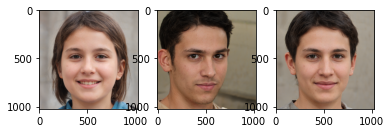

In [ ]:
from matplotlib import pyplot as plt

fix, axes = plt.subplots(1, 3)

imgs = [img_p, img_g, img_pg]

for (ax, img) in zip(axes, imgs):
    img = tf.squeeze(img)
    img = (img + 1) * 127.5
    ax.imshow(img.numpy().astype(np.uint8))

## Test gradient calculation

In [ ]:
with tf.GradientTape(watch_accessed_variables=False) as tape:
    tape.watch(ps)
    img_pg = get_merged([latents_p, latents_g, labels], truncation_psi)
    red_sum = tf.reduce_sum(img_pg)
    grads = tape.gradient(red_sum, Gs.trainable_variables)  
# Assert that only gradients for ps are tracked    
assert len([grad for grad in grads if not grad == None]) == len(ps)

# Training preparation

## Load network for perceptual loss and freeze it 

In [ ]:
# TODO: remove unnecessary layers
perc_base_net = tf.keras.applications.EfficientNetB0()
# Freeze perc_base_net since we don't want to train it
perc_base_net.trainable = False

In [ ]:
layer_names = ("block1a_project_conv", "block2b_project_conv", "block3b_project_conv", 
               "block4c_project_conv", "block5c_project_conv", "block6d_project_conv",
               "block7a_project_conv")

# layer_indices = []
used_layers = []

# for i, layer in enumerate(vgg.layers):
#     used_layers.append(layer)
#     if layer.name in layer_names:
#         layer_indices.append(i)
#         if len(layer_indices) == len(layer_names):
#             break

used_layers = [perc_base_net.get_layer(layer_name).output for layer_name in layer_names]

perc_net = tf.keras.Model(inputs=perc_base_net.inputs, outputs=used_layers)

# Hopefully save memory this way         
del perc_base_net
tf.keras.backend.clear_session()

NUM_LAYERS = len(layer_names)

## Define perceptual loss

In [ ]:
@tf.function
def perc_loss(real, fake):
    # TODO: Better description. Also maybe more detail? Point to equation
    """Returns perceptual loss according to VGG16 activations. See 
    """
    
    real = tf.image.resize(real, [224, 224])
    real = tf.keras.applications.efficientnet.preprocess_input(real)

    fake = tf.image.resize(fake, [224, 224])
    fake = tf.keras.applications.efficientnet.preprocess_input(fake)

    real = perc_net(real)
    fake = perc_net(fake)

    real_out = real[0]
    fake_out = fake[0]

    # normalize in channel dimension
    layer_loss = tf.math.l2_normalize(real_out, axis=-1)
    layer_loss -= tf.math.l2_normalize(fake_out, axis=-1)

    layer_loss = tf.norm(layer_loss, axis=-1)
    layer_loss = tf.square(layer_loss)
    layer_loss = tf.reduce_mean(layer_loss)

    loss = layer_loss

    for i in range(1, NUM_LAYERS):
        real_out = real[i]
        fake_out = fake[i]

        # normalize in channel dimension
        layer_loss = tf.math.l2_normalize(real_out, axis=-1)
        layer_loss -= tf.math.l2_normalize(fake_out, axis=-1)

        layer_loss = tf.norm(layer_loss, axis=-1)
        layer_loss = tf.square(layer_loss)
        layer_loss = tf.reduce_mean(layer_loss)

        loss = loss + layer_loss

    return loss         

## Instantiate loss trackers

In [ ]:
GLOBAL_LOSS_TRACKER = tf.keras.metrics.Mean()

## Instantiate train writer

In [ ]:
import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# Set log directory
LOG_DIR = PRT_DIR + "logs/encoder/" + current_time 

TRAIN_WRITER = tf.summary.create_file_writer(LOG_DIR)

## Instantiate optimizer

In [ ]:
LEARNING_RATE = 0.001
OPTIMIZER = tf.keras.optimizers.Adam(LEARNING_RATE)